# Grover

## Grover's algorithm

Grover's algorithm has three main components:
- an input preparation stage, in which we prepare a state $|s\rangle$. In the original Grover's framework $|s\rangle = \frac{1}{\sqrt{2^n}}\sum |i\rangle$
- a diffusion operator $\mathcal{D} = 2 |s\rangle\langle s| - I$
- an oracle "marking" some basis states by flipping their phases: $O_f = \sum_i (-1)^{f(i)}|i\rangle\langle i|$ for some boolean predicate $f$


### Input preparation

In [56]:
from qat.lang.AQASM import *

@build_gate("IN", [int])
def inputop(nbqbits):
    rout = QRoutine()
    wires = rout.new_wires(nbqbits)
    # a compute context to simplify gate application writing
    with rout.compute():
        for wire in wires:
            H(wire)
    return rout


### Diffusion operator

Lets first start by programming a piece of pyAQASM code that will generate a diffusion operator.
$\mathcal{D}$ can be obtained by:
- performing a basis change from the computation basis to the diagonal basis (i.e a cascade of H gates)
- performing a collectiong of bit flips in order to send the $|0^n\rangle$ state onto $|1^n\rangle$
- performing a "global" controlled-Z gate in order to flip the phase of $|0^n\rangle$
- undoing the bit flips
- undoing the basis change


This can be easily expressed in pyAQASM as follows:

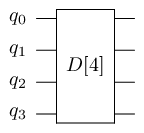

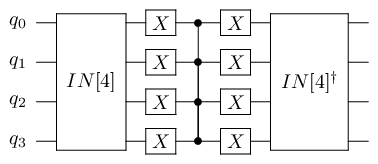

In [42]:
@build_gate("DIFF", [int], arity=lambda n: n)
def diffusion(nbqbits):
    rout = QRoutine()
    wires = rout.new_wires(nbqbits)
    rout2 = inputop(nbqbits)
    rout.apply(rout2, wires)
    with rout.compute():
        for wire in wires:
            X(wire)
    Z.ctrl(nbqbits - 1)(wires)
    rout.uncompute()
    rout.apply(rout2.dag(), wires)
    return rout

example = diffusion(4)
%qatdisplay example
%qatdisplay example --depth 1


### Oracle

Fixed string oracle.



In [57]:
@build_gate("ORACLE", [int, str])
def fixed_string_oracle(nbqbits, bitstring):
    """Returns an oracle producing a phase flip only for the given bitstring"""
    qrout = QRoutine()
    qreg = qrout.new_wires(nbqbits)
    for bit, qbit in zip(bitstring, qreg):
        if bit == "0":
            qrout.apply(X, qbit)
        elif bit != "1":
            raise Exception("Only 0's and 1's admissible")
    qrout.apply(Z.ctrl(nbqbits-1), qreg[:-1], qreg[-1])
    for bit, qbit in zip(bitstring, qreg):
        if bit == "0":
            qrout.apply(X, qbit)
            
    return qrout
    

### All together

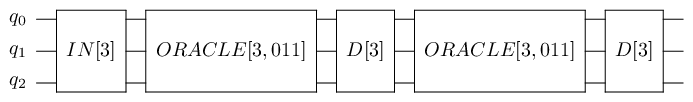

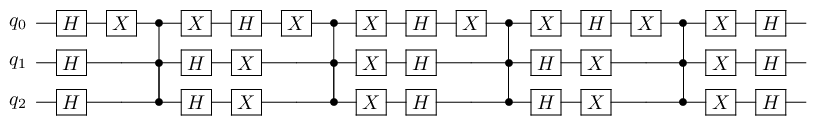

In [60]:
from math import sqrt, ceil, pi, asin
nqbits = 3
pr = Program()
qr = pr.qalloc(nqbits)

iters = int(ceil(pi/(4*asin(1/sqrt(2**3))) - 1/2))
inpo = inputop(nqbits)
difo = diffusion(nqbits)
oracleo = fixed_string_oracle(nqbits, "011")

pr.apply(inpo, qr)
for _ in range(iters):
    pr.apply(oracleo, qr)
    pr.apply(difo, qr)
    
cr = pr.to_circ()
%qatdisplay cr
%qatdisplay cr --depth=2

In [61]:
from qat.qpus import PyLinalg
qpu = PyLinalg()
res = qpu.submit(cr.to_job())
for sample in res:
    print(f"State {sample.state} with amplitude {sample.amplitude} and probability {sample.probability}")

State |000> with amplitude (-0.08838834764831832+0j) and probability 0.007812499999999979
State |001> with amplitude (-0.08838834764831825+0j) and probability 0.007812499999999967
State |010> with amplitude (-0.08838834764831832+0j) and probability 0.007812499999999979
State |011> with amplitude (0.9722718241315016+0j) and probability 0.9453124999999976
State |100> with amplitude (-0.08838834764831832+0j) and probability 0.007812499999999979
State |101> with amplitude (-0.08838834764831825+0j) and probability 0.007812499999999967
State |110> with amplitude (-0.08838834764831832+0j) and probability 0.007812499999999979
State |111> with amplitude (-0.08838834764831821+0j) and probability 0.007812499999999959


In [67]:
cr.to_job?